In [19]:
import numpy as np 
import pandas as pd

import xgboost as xgb
import pickle

from sklearn import metrics
from sklearn import preprocessing
from sklearn import impute
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack, vstack


import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

import sys
import os 

sys.path.append('..')
from src import config

if sys.platform == 'linux':
    path = config.LINUX_PATH
else:
    path = config.OS_PATH
os.chdir(path)

data_path = config.STRAVA_TRAIN_PATH
data = pd.read_csv(data_path, index_col=0)

def map_time_of_day(hour):
    
    if hour in [6,7,8,9,10]:
        return 'AM'
    
    elif hour in [11,12,13,14,15]:
        return 'Mid'
    
    elif hour in [16,17,18,19,20]:
        return 'PM'
    
    else:
        return 'Night'

data['hour_binned'] = data['hour'].apply(map_time_of_day)
print(data.columns.tolist())
data.head()

['name', 'distance', 'moving_time', 'total_elevation_gain', 'workout_type', 'timezone', 'achievement_count', 'kudos_count', 'manual', 'max_speed', 'average_heartrate', 'max_heartrate', 'pr_count', 'total_photo_count', 'suffer_score', 'has_photo', 'is_named', 'GMT_date', 'GMT_time', 'local_date', 'local_time', 'run_per_day', 'max_run', 'datetime', 'year', 'weekofyear', 'month', 'dayofweek', 'weekend', 'hour', 'is_uk_awake', 'run_area', 'latlng_cluster', 'city', 'average_speed_mpk', 'hour_binned']


,name,distance,moving_time,total_elevation_gain,workout_type,timezone,achievement_count,kudos_count,manual,max_speed,...,month,dayofweek,weekend,hour,is_uk_awake,run_area,latlng_cluster,city,average_speed_mpk,hour_binned
284,🐅,10.4163,45.566667,18.0,0.0,America/Boise,1,29,False,5.0,...,3,2,0,15,1,5.428935,1,Boise,4.374278,Mid
285,🦏,16.1663,70.250000,20.0,0.0,America/Boise,5,36,False,5.3,...,3,2,0,8,1,16.859057,1,Boise,4.345763,AM
286,💩,1.6812,8.166667,8.0,0.0,America/Boise,0,14,False,5.7,...,3,1,0,15,1,0.017541,1,Boise,4.857476,Mid
287,🦧,12.8514,42.183333,21.0,3.0,America/Boise,0,56,False,6.5,...,3,1,0,14,1,0.535336,1,Boise,3.282001,Mid
288,🆙,3.3194,15.300000,3.0,0.0,America/Boise,0,8,False,6.9,...,3,1,0,14,1,0.008149,1,Boise,4.608960,Mid


In [32]:
def run(fold):

    # read training data with folds
    df = pd.read_csv(config.STRAVA_TRAIN_KFOLD_PATH)

    # list all numeric features
    num_cols = [
        "distance",
        "moving_time",
        "total_elevation_gain",
        "max_speed",
        "average_heartrate",
        "max_heartrate",
        "suffer_score",
        "run_area",
        "average_speed_mpk",
    ]

    cat_cols = [
        "workout_type",
        "timezone",
        "manual",
        "dayofweek",
        "weekend",
        "is_uk_awake",
        "latlng_cluster",
        "city",
        "has_photo",
        "run_per_day",
        "max_run",
        "is_named",
    ]

    ordinal_cols = ["hour", "pr_count", "hour_binned"]

    # all cols are features except for target and kfold
    features = num_cols + cat_cols + ordinal_cols

    # fill cat column NaN values with NONE
    for col in cat_cols + ordinal_cols:
        df.loc[:, col] = df[col].astype(str).fillna("NONE")

    # training data is where kfold is not equal to fold
    df_train = df[df.kfold != fold].reset_index(drop=True)
    y_train = df_train.kudos_count.values

    # validation data is where kfold = fold
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    y_valid = df_valid.kudos_count.values

    # pipelines for model transformation
    num_pipeline = Pipeline([("imputer", impute.SimpleImputer(strategy="median"))])

    cat_pipeline = Pipeline(
        [("cat", preprocessing.OneHotEncoder(handle_unknown="ignore"))]
    )

    # transforms columns and drops columns not specified
    x_train_num = num_pipeline.fit_transform(df_train[num_cols])
    x_train_cat = cat_pipeline.fit_transform(df_train[cat_cols + ordinal_cols])
    x_valid_num = num_pipeline.transform(df_valid[num_cols])
    x_valid_cat = cat_pipeline.transform(df_valid[cat_cols + ordinal_cols])

    # get feature names
    cat_feature_names = cat_pipeline.named_steps['cat'].get_feature_names(cat_cols + ordinal_cols)

    # check shapes are the same
    assert (
        x_train_num.shape[0] == y_train.shape[0]
    ), "training data (numeric) and label dimension are not equal"

    assert (
        x_train_cat.shape[0] == y_train.shape[0]
    ), "training data (categorical) and label dimension are not equal"

    assert (
        x_valid_num.shape[0] == y_valid.shape[0]
    ), "validation data (numeric) and label dimension are not equal"

    assert (
        x_valid_cat.shape[0] == y_valid.shape[0]
    ), "validation data (categorical) and label dimension are not equal"

    # join numeric data and categorical data
    x_train = hstack((x_train_num, x_train_cat), format="csr")
    x_valid = hstack((x_valid_num, x_valid_cat), format="csr")

    # initialize xgboost model
    model = xgb.XGBRegressor(n_jobs=-1)

    # fit model on training data
    eval_set = [(x_valid, y_valid)]
    model.fit(
        x_train,
        y_train,
        early_stopping_rounds=10,
        eval_metric="rmse",
        eval_set=eval_set,
        verbose=False,
    )
    # model.fit(x_train, y_train)

    # predict on validation data
    valid_preds = model.predict(x_valid)

    # get rmse, and mape
    rmse = metrics.mean_squared_error(y_valid, valid_preds, squared=False)
    max_error = metrics.max_error(y_valid, valid_preds)
    print(f"\nFold = {fold}, rmse = {rmse}, max error = {max_error}")

    data = [x_train, y_train, x_valid, y_valid]
    features = list(num_cols) + list(cat_feature_names)

    return rmse, model, data, features

scores = []
for fold_ in range(3):
    rmse, model, data, features = run(fold_)
    scores.append(rmse)
print(f"\nAverage rmse = {sum(scores) / len(scores)}")


Fold = 0, rmse = 9.127026504595753, max error = 32.5067138671875

Fold = 1, rmse = 8.648736838767862, max error = 33.03307342529297

Fold = 2, rmse = 11.41962387438861, max error = 56.410614013671875

Average rmse = 9.73179573925074



Fold = 0, rmse = 9.127026504595753, max error = 32.5067138671875


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

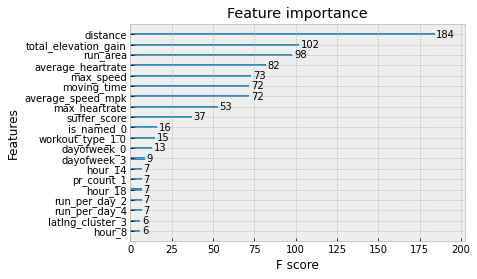

In [43]:
# default feature_importance
rmse, model, data, features = run(0)
model.get_booster().feature_names = features
f = 'gain'
model.get_booster().get_score(importance_type= f)
xgb.plot_importance(model, max_num_features=20)
# print(model.feature_importances_)
# sorted(zip(model.feature_importances_, features), reverse=True)


Fold = 0, rmse = 9.591987168769444, max error = 34.15229034423828
['distance', 'workout_type_1.0', 'average_speed_mpk', 'suffer_score', 'max_run_0', 'is_named_0', 'workout_type_0.0', 'run_area', 'moving_time', 'total_elevation_gain']


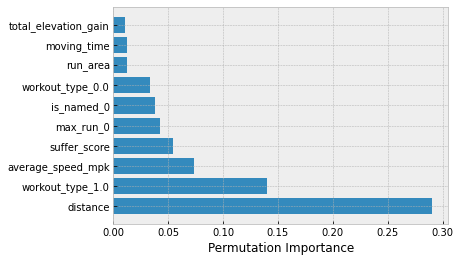

In [97]:
from sklearn.inspection import permutation_importance

def train(fold):

    # read training data with folds
    df = pd.read_csv(config.STRAVA_TRAIN_KFOLD_PATH)

    # list all numeric features
    num_cols = [
        "distance",
        "moving_time",
        "total_elevation_gain",
        "max_speed",
        "average_heartrate",
        "max_heartrate",
        "suffer_score",
        "run_area",
        "average_speed_mpk",
    ]

    cat_cols = [
        "workout_type",
        "timezone",
        "manual",
        "dayofweek",
        "weekend",
        "is_uk_awake",
        "latlng_cluster",
        "city",
        "has_photo",
        "run_per_day",
        "max_run",
        "is_named",
    ]

    ordinal_cols = ["hour", "pr_count", "hour_binned"]

    # all cols are features except for target and kfold
    features = num_cols + cat_cols + ordinal_cols

    # fill cat column NaN values with NONE
    for col in cat_cols + ordinal_cols:
        df.loc[:, col] = df[col].astype(str).fillna("NONE")

    # training data is where kfold is not equal to fold
    df_train = df[df.kfold != fold].reset_index(drop=True)
    y_train = df_train.kudos_count.values

    # validation data is where kfold = fold
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    y_valid = df_valid.kudos_count.values

    # pipelines for model transformation
    num_pipeline = Pipeline([("imputer", impute.SimpleImputer(strategy="median"))])

    cat_pipeline = Pipeline(
        [("cat", preprocessing.OneHotEncoder(handle_unknown="ignore"))]
    )

    # transforms columns and drops columns not specified
    x_train_num = num_pipeline.fit_transform(df_train[num_cols])
    x_train_cat = cat_pipeline.fit_transform(df_train[cat_cols + ordinal_cols])
    x_valid_num = num_pipeline.transform(df_valid[num_cols])
    x_valid_cat = cat_pipeline.transform(df_valid[cat_cols + ordinal_cols])

    # get feature names
    cat_feature_names = cat_pipeline.named_steps['cat'].get_feature_names(cat_cols + ordinal_cols)

    # join numeric data and categorical data
    x_train = hstack((x_train_num, x_train_cat), format="csr").todense()
    x_valid = hstack((x_valid_num, x_valid_cat), format="csr").todense()
    
    # initialize xgboost model
    model = xgb.XGBRegressor(n_jobs=-1)

    # fit model on training data
    eval_set = [(x_valid, y_valid)]
    model.fit(
        x_train,
        y_train,
        early_stopping_rounds=10,
        eval_metric="rmse",
        eval_set=eval_set,
        verbose=False,
    )
    # model.fit(x_train, y_train)

    # predict on validation data
    valid_preds = model.predict(x_valid)

    # get rmse, and mape
    rmse = metrics.mean_squared_error(y_valid, valid_preds, squared=False)
    max_error = metrics.max_error(y_valid, valid_preds)
    print(f"\nFold = {fold}, rmse = {rmse}, max error = {max_error}")

    data = [x_train, y_train, x_valid, y_valid]
    features = list(num_cols) + list(cat_feature_names)

    return rmse, model, data, features  

rmse, model, data, features = train(0)

perm_importance = permutation_importance(model, data[2], data[3])
sorted_idx = np.argsort(perm_importance.importances_mean)[::-1][:10] #[::-1][:20]
feat = [features[i] for i in sorted_idx]
importances = [perm_importance.importances_mean[i] for i in sorted_idx]
plt.barh(feat, importances)
plt.xlabel("Permutation Importance")
print(feat)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


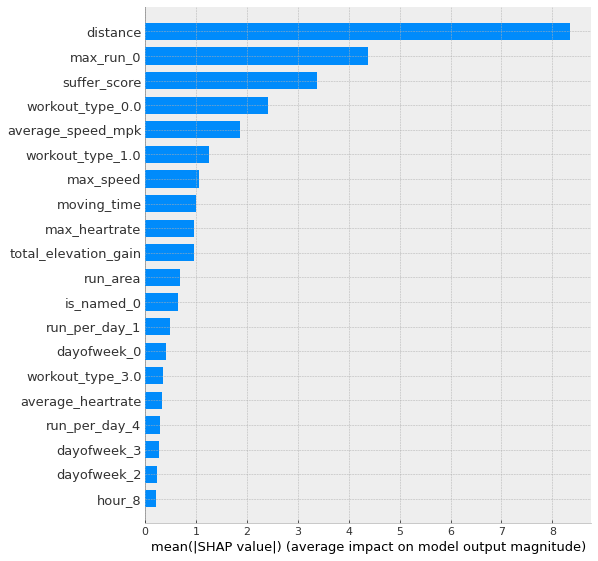

,col_name,feature_importance_vals
0,distance,8.350497
67,max_run_0,4.384684
6,suffer_score,3.386624
9,workout_type_0.0,2.406366
8,average_speed_mpk,1.859995
10,workout_type_1.0,1.262329
3,max_speed,1.056263
1,moving_time,0.992473
5,max_heartrate,0.952603
2,total_elevation_gain,0.952195


In [109]:
import shap 
model.get_booster().feature_names = features
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data[2])
shap.summary_plot(shap_values, data[2], plot_type="bar", feature_names=features)

vals = np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(features,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.head(15)